In [125]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification, make_blobs, fetch_openml
import sklearn.datasets as datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype


class PrismRules:
    def __init__(self, min_coverage=10, min_prob=0.75, nbins=3, verbose=0):
        """
        Class to generate PRISM rules for a supplied dataset.

        :param min_coverage: The minimum number of rows each rule must cover.
        :param min_prob: The minimum probability for each rule. The target class must be the target value in the
            remaining rows (the rows not covered by previous rules) with at least this probability.
        :param nbins: The number of bins each numeric column is divided into.
        :param verbose: If 0, no output is produced other than the induced rules. If 1, progress indication is
            presented as each rule is induced.
        """

        self.min_coverage = min_coverage
        self.min_prob = min_prob
        self.nbins = nbins
        self.bin_ranges = {}
        self.verbose = verbose
        self.default_target = None
        self.predict_dict = {}
        self.target_column = ""

        # For improved performance, integer values are used for each value. This dictionary maps the integer codes
        # to the original values, and is used to display the rules and target values. Where the column is numeric,
        # this maps to the bin label.
        self.int_to_values_map = {}

    def __get_next_term(self, df, target_col, target_val, cols_exclude_list):
        """
        Get the next term (a column-value pair) for the current rule.

        :param df: The dataframe for the current rule. This is the set of rows matching the rule so far.
        :param target_col: Target column
        :param target_val: The current target value within the target column
        :param cols_exclude_list: Columns for which we already have terms for this rule.
        :return: a single term in tuple format, with a column name and value from that column, along with the
            probability and coverage (frequency) of the rule on the remaining rows.
        """

        max_prob = -1
        # In the event of ties with respect to probability, we take the term with the greatest frequency
        max_prob_freq = 0
        term = None
        for col_name in df.drop(columns=[target_col]).columns:
            if col_name in cols_exclude_list:
                continue
            for val in df[col_name].unique():
                sub_df_1 = df[df[col_name] == val]
                sub_df_2 = df[(df[col_name] == val) & (df[target_col] == target_val)]
                prob = len(sub_df_2) / len(sub_df_1)
                freq = len(sub_df_2)
                if freq < self.min_coverage:
                    continue
                if (prob > max_prob) or ((prob == max_prob) and (freq > max_prob_freq)):
                    max_prob = prob
                    max_prob_freq = freq
                    term = (col_name, val, prob, freq)
        return term

    def __get_next_rule(self, df_rule, target_col, target_val):
        """
        Given a specified target_val in the target_col, find the first or next rule. If not the first, the dataframe
        should just contain rows not covered by the previous rules for this target value.

        :param df_rule: the full original dataframe, minus the rows covered by other rules for the current target
        :param target_col: the target column
        :param target_val: the target value
        :return: a list of terms for the new rule, and a dataframe with the rows for this rule
        """

        terms_list = []
        cols_exclude_list = []  # Do not create terms for the same feature in the same rule
        df = df_rule.copy()
        target_val_remaining = df[target_col].tolist().count(target_val)
        len_df = len(df)
        while target_val_remaining < len_df:
            term = self.__get_next_term(df, target_col, target_val, cols_exclude_list)
            if term is None:
                break
            col, val, prob, freq = term
            cols_exclude_list.append(col)
            if len(cols_exclude_list) == (len(df.columns) - 1):
                break
            df = df[(df[col] == val)]
            terms_list.append((term, df))
            target_val_remaining = df[target_col].tolist().count(target_val)
            len_df = len(df)

        # Check the terms list for the optimal set of terms, which is the set with the highest probability of the
        # target class given the terms.
        max_prob = 0
        max_prob_idx = -1
        max_prob_df = None
        for term_idx, term in enumerate(terms_list):
            if term[0][2] > max_prob:
                max_prob = term[0][2]
                max_prob_idx = term_idx
                max_prob_df = term[1]
        optimal_terms_list = terms_list[:max_prob_idx + 1]
        optimal_terms_list = [x for x, y in optimal_terms_list]

        if max_prob < self.min_prob:
            return None, None

        # Convert the integer codes used in the dataframe to the original values for the relevant column
        formatted_terms = []
        for t in optimal_terms_list:
            if t[1] == "NONE":
                formatted_terms.append(t)
            else:
                formatted_terms.append((t[0], self.int_to_values_map[t[0]][t[1]], t[2], t[3]))

        return formatted_terms, max_prob_df

    def __get_rules_for_target_val(self, df_full, target_col, target_val):
        """
        Get the full set of rules for the specified value in the target column
        :param df_full:
        :param target_col:  Name of target column
        :param target_val:  Value in the target column for which this execution of this function generates rules.
        :return: array of strings.
        """

        rules_for_val = []
        num_rows_curr_target = df_full[target_col].tolist().count(target_val)
        df = df_full.copy()  # Create a temporary dataframe that shrinks as the rules are formed
        is_first_rule = True
        target_val_remaining = df[target_col].tolist().count(target_val)
        while target_val_remaining > self.min_coverage:
            if self.verbose:
                print(f"  Determining next rule. {target_val_remaining:,} rows remaining for target class")
            num_rows_curr_target_remaining = df[target_col].tolist().count(target_val)
            terms_list, rule_df = self.__get_next_rule(df, target_col, target_val)
            if not terms_list:
                break

            if target_val in self.predict_dict:
                self.predict_dict[target_val].append(terms_list)
            else:
                self.predict_dict[target_val] = [terms_list]

            # Add a rule in string format representing the list of terms returned
            rule_str = ""
            for term in terms_list:
                rule_str += str(term[0]) + " = " + str(term[1]) + " AND "
            rule_str = rule_str[:-5]  # Remove the trailing "AND"
            num_matching_target = rule_df[target_col].tolist().count(target_val)
            rule_str += "\n   Support:  "
            if is_first_rule:
                rule_str += f"the target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} rows matching the rule "
                rule_str += "\n   Coverage: "
                rule_str += f"the rule matches: {num_matching_target} out of {num_rows_curr_target} rows "
                rule_str += f"for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
            else:
                rule_str += f"The target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} remaining rows matching the "
                rule_str += "rule"
                rule_str += "\n   Coverage: "
                rule_str += f"The rule matches: {num_matching_target} out of {num_rows_curr_target_remaining} rows "
                rule_str += f"remaining for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
                rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target_remaining):.3f}% of "
                rule_str += f"remaining rows for target value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target):.3f}% of total rows for target "
            rule_str += f"value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / len(df_full)):.3f}% of total rows in data"
            rules_for_val.append(rule_str)
            is_first_rule = False

            # Remove all rows for this rule
            df = df.loc[list(set(df.index) - set(rule_df.index))]
            target_val_remaining = df[target_col].tolist().count(target_val)
        return rules_for_val

    def __display_rules(self, df, target_col, rules_dict, display_stats):
        for target_val in rules_dict:
            print()
            print('........................................................................')
            print(f"Target: {self.int_to_values_map[target_col][target_val]}")
            print('........................................................................')
            if len(rules_dict[target_val]) == 0 and display_stats:
                print((f"  No rules imputed for target value {self.int_to_values_map[target_col][target_val]}. There "
                       f"are {df[target_col].tolist().count(target_val)} rows for this class."))
            for r in rules_dict[target_val]:
                if display_stats:
                    print(r)
                else:
                    print(r.split("\n")[0])

    def get_prism_rules(self, df, target_col, display_stats=True):
        """
        Given a dataframe with a specified target column, find a set of rules that describe the patterns associated
        with the target column. The rules are displayed in a formatted form.

        :param df: pandas dataframe. Must include the target column.
        :param target_col: Name of the target column
        :param display_stats: If True, the support and coverage for each rule will be displayed
        :return: array of strings, with each element of the array representing one rule.
        """

        # PRISM requires all columns be categorical, so bin any numeric features, including the target column if
        # necessary.
        new_vals_dict = {}
        for col_name in df.columns:
            if is_numeric_dtype(df[col_name]) and (df[col_name].nunique() > 10):
                try:
                    if self.nbins == 3:
                        vals = ['Low', "Med", 'High']
                        bin_ids, bin_ranges = pd.qcut(df[col_name], 3, labels=vals, retbins=True)
                    else:
                        vals = [f"Bin_{x}" for x in range(self.nbins)]
                        bin_ids, bin_ranges = pd.qcut(df[col_name], self.nbins, labels=vals, retbins=True)
                    self.bin_ranges[col_name] = bin_ranges
                    vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                    int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                    new_vals_dict[col_name] = bin_ids.map(vals_to_int_map)
                    self.int_to_values_map[col_name] = int_to_vals_map
                except:
                    # The qcut() method may fail if the data is sufficiently skewed, and the bins are non-unique, In
                    # this case we do not include the column in the model.
                    pass
            else:
                vals = df[col_name].unique()
                vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                new_vals_dict[col_name] = df[col_name].map(vals_to_int_map)
                self.int_to_values_map[col_name] = int_to_vals_map
        df = pd.DataFrame(new_vals_dict)

        # Remove any columns with only 1 unique value
        drop_cols = []
        for col_name in df.columns:
            if df[col_name].nunique() < 2:
                drop_cols.append(col_name)
        df = df.drop(columns=drop_cols)

        # Fill any NaN and None values
        for col_name in df.columns:
            if df[col_name].dtype.name == "category":
                df[col_name] = df[col_name].cat.add_categories("NONE").fillna("NONE")
            else:
                df[col_name] = df[col_name].fillna("NULL")

        # Loop through each value in the target column and find the set of rules for this value
        target_vals = sorted(df[target_col].unique())
        if self.verbose:
            print(f"Determining rules for each of {len(target_vals)} target classes:")
        rules_dict = {}
        for target_val in target_vals:
            if self.verbose >= 1:
                print(f"Determining rules for target class: {self.int_to_values_map[target_col][target_val]}")
            rules_dict[target_val] = self.__get_rules_for_target_val(df, target_col, target_val)

        self.__display_rules(df, target_col, rules_dict, display_stats)

        self.default_target = df[target_col].mode().values[0]
        self.target_column = target_col

        return rules_dict

    def predict(self, X_in, leave_unknown=False):
        X = X_in.copy()
        X = X.reset_index(drop=True)
        if leave_unknown:
            ret = ["NO PREDICTION"]*len(X)
        else:
            ret = [self.default_target]*len(X)
        is_set = [False]*len(X)

        for col_name in X.columns:
            if col_name not in self.bin_ranges:
                continue
            bin_ranges = self.bin_ranges[col_name]
            for i in range(len(X)):
                v = X.loc[i, col_name]
                for bin_idx, bin_limit in enumerate(bin_ranges):
                    if v < bin_limit:
                        X.loc[i, col_name] = bin_idx - 1
                        break
            if col_name in self.int_to_values_map:
                X[col_name] = X[col_name].map(self.int_to_values_map[col_name])

        for i in range(len(X)):
            row = X.iloc[i]
            found_rule = False
            for key in self.predict_dict.keys():
                rules = self.predict_dict[key]
                for rule in rules:
                    all_terms_true = True
                    for term in rule:
                        term_feature_name = term[0]
                        term_value = term[1]
                        if row[term_feature_name] != term_value:
                            all_terms_true = False
                            break
                    if all_terms_true:
                        ret[i] = key
                        is_set[i] = True
                        found_rule = True
                        break
                if found_rule:
                    break
        ret = pd.Series(ret).map(self.int_to_values_map[self.target_column])
        if leave_unknown:
            ret = ret.fillna("NO PREDICTION")
            ret = ret.astype(str)
        return ret

    def get_bin_ranges(self):
        if self.bin_ranges is None:
            print("No columns were binned.")
        else:
            return self.bin_ranges


In [126]:
# load dataset
pd.set_option('display.max_columns', None) # Display all columns

url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/wine_data.csv"
df = pd.read_csv(url)
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
0,13.73,1.50,2.70,22.5,101.0,3.00,3.25,0.29,2.38,5.70,1.19,2.71,1285.0,0
1,14.13,4.10,2.74,24.5,96.0,2.05,0.76,0.56,1.35,9.20,0.61,1.60,560.0,2
2,12.16,1.61,2.31,22.8,90.0,1.78,1.69,0.43,1.56,2.45,1.33,2.26,495.0,1
3,13.07,1.50,2.10,15.5,98.0,2.40,2.64,0.28,1.37,3.70,1.18,2.69,1020.0,0
4,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0


The unique values in the 'Y' column represent the different class of wine:
- 0: Wine Class 0
- 1: Wine Class 1
- 2: Wine Class 2

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  Y    

Insights : the output shows that all columns in the dataframe have 178 non-null entries. This means there are no missing values in any of the columns

In [128]:
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


Insights :    
- Average alcohol content is 13.0%, ranging from 11.0–14.8% — most wines are medium to high alcohol.
- Mean of the malic_acid 2.33 but with high variability (std = 1.12, max = 5.8). Indicates large differences in acidity among wines.
- Most wines have ash around 2.36, suggesting consistent mineral content.
- Wide range (10.6–30.0) and large std (3.34), showing significant variation in alkalinity, which can affect taste and acidity.
- Magnesium average 99.7, range 70–162, some outliers likely come from wines grown in mineral-rich soil.
- The dataset shows strong variability in key features like malic_acid, flavanoids, color_intensity, and alcalinity_of_ash.
- Features like ash and nonflavanoid_phenols are more stable, serving as control or secondary attributes.

In [129]:
df = df.sample(n=len(df)) # Shuffle the rows
print("Number of rows:", len(df))

Number of rows: 178


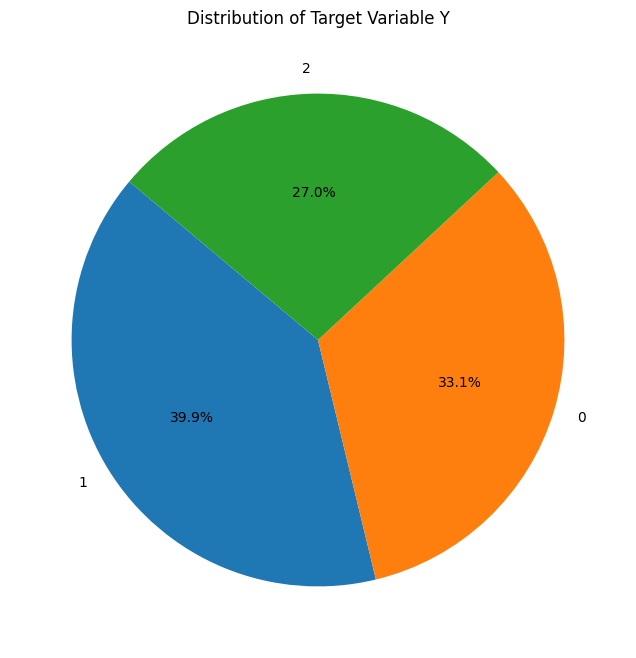

In [130]:
# Get the counts of each unique value in the 'Y' column
y_counts = df['Y'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(y_counts, labels=y_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Target Variable Y')
plt.show()

Insights : The pie chart shows the distribution of the target variable 'Y', which represents the different wine classes. From the chart, we can see the proportion of wines belonging to each class (0, 1, and 2). The highest percentage is wine class 1 for 39.9%, the lowest percentage is wine class 2 for 27%

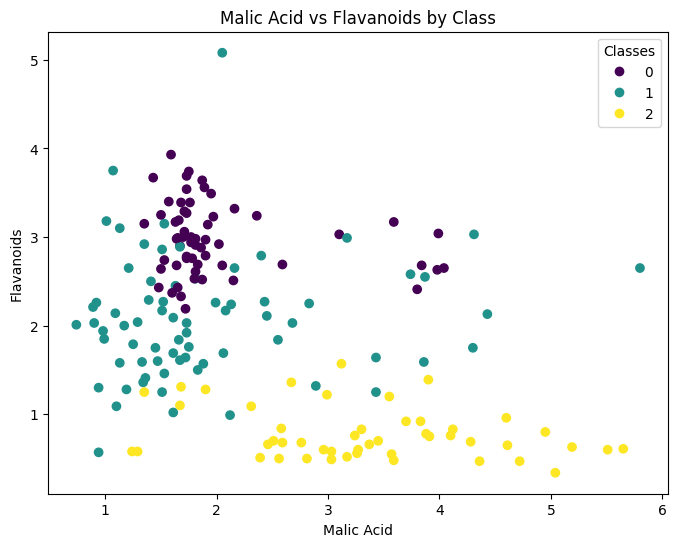

In [131]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['malic_acid'], df['flavanoids'], c=df['Y'], cmap='viridis')
plt.xlabel('Malic Acid')
plt.ylabel('Flavanoids')
plt.title('Malic Acid vs Flavanoids by Class')
legend = plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()

Insights :     
- Class 0 (purple dots) : clustered around low to moderate malic acid (1-3) and has high flavanoids (2.5-4), indicates wines class in class 0 are typically richer in flavanoids and less acidic
- Class 1 (teal dots) : spread across a wider malid acid range (1-5) and moderate flavanoids (1.5-3), overlaps with both class 0 and class 2, suggesting medium characteristic between them, likely represent intermediate wines in both acidity and flavanoid content
- Class 2 (yellow dots) : mostly found at higher malic acid (2-5) and lower flavanoid (0.5-1.5), indicates wines that are more acidic and lower in flavanoids, possibly lighter or less rich in taste.
- There is a negative relationship between Malic Acid and Flavanoids across the dataset as acidity increases, flavanoid levels tend to decrease.
- Class 0 and Class 2 are well separated, showing clear biochemical differences between these wine types.
- Class 1 overlaps with both, which might make it harder to classify based on these two features alone, other variables (like alcohol or color intensity) might help improve separation.

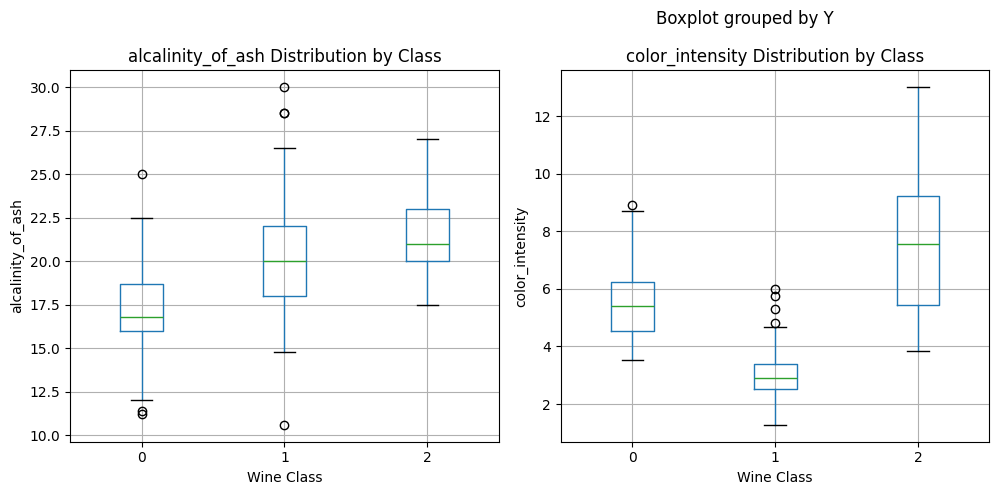

In [132]:
features_to_plot = ['alcalinity_of_ash', 'color_intensity']

plt.figure(figsize=(15, 5))
for i, feature in enumerate(features_to_plot):
    plt.subplot(1, 3, i + 1)
    df.boxplot(column=feature, by='Y', ax=plt.gca())
    plt.title(f'{feature} Distribution by Class')
    plt.xlabel('Wine Class')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

Insights :     
For alcalinity_of_ash, wines in Class 0 tend to have lower values, with most data points centered around 16 to 18 and a few outliers below 12 and above 25. Class 1 shows a wider range of alkalinity, stretching from around 10 to 30, and has the highest variability among the three classes. This suggests that wines in Class 1 are chemically more diverse in terms of ash alkalinity. Meanwhile, Class 2 wines have slightly higher median values around 21 to 22, with a tighter distribution, meaning that their alkalinity is generally higher and more consistent compared to the other classes. Overall, alcalinity_of_ash tends to increase from Class 0 to Class 2.

In contrast, the color_intensity plot shows a much clearer separation between the classes. Class 0 wines have a moderate color intensity, with a median around 5.5, while Class 1 wines are noticeably lighter in color, with most values concentrated between 2 and 4.5 and a median around 3. On the other hand, Class 2 wines are much darker, with a median near 8 and several samples reaching above 10 or even 13. This indicates that color intensity is a strong distinguishing feature among the wine classes, effectively separating lighter wines (Class 1) from darker and richer wines (Class 2).

# Generate Rules with PRISM

Train 80%, Test 20%

In [133]:
# since we dont do any partitioning bcs we have to use both X and Y in our 'prism' model, so let's just use 100 rows for this training and the rest for the testing

# PRISM requires all columns be categorical, so bin any numeric features, including the target column if necessary, BUT there's a binning function in 'get_prism_rules', so we dont need to binning it manually first.

prism = PrismRules()
_ = prism.get_prism_rules(df.head(100), 'Y')


........................................................................
Target: 0
........................................................................
proline = High AND flavanoids = High
   Support:  the target has value: '0' for 100.000% of the 24 rows matching the rule 
   Coverage: the rule matches: 24 out of 31 rows for target value: '0'. This is:
      77.419% of total rows for target value: '0'
      24.000% of total rows in data

........................................................................
Target: 1
........................................................................
color_intensity = Low
   Support:  the target has value: '1' for 100.000% of the 33 rows matching the rule 
   Coverage: the rule matches: 33 out of 45 rows for target value: '1'. This is:
      73.333% of total rows for target value: '1'
      33.000% of total rows in data

........................................................................
Target: 2
.....................................

Insights :     
Class 0 Wines : If proline is High and flavanoids are High → Class 0, meaning that wines with both high proline and high flavonoid content tend to belong to Class 0. This rule perfectly identifies all wines that meet these criteria as Class 0, covering approximately 77% of all Class 0 samples and 24% of the total dataset. These chemical indicators suggest that Class 0 wines are characterized by a strong biochemical composition, particularly higher amino acid (proline) and antioxidant (flavonoid) levels. Such wines are likely richer in structure and flavor complexity, possibly representing full-bodied and mature varieties.

Class 1 Wines : If color_intensity is Low → Class 1, meaning that wines with lower color intensity values are strongly associated with Class 1. This rule correctly identifies all wines meeting this condition as Class 1, covering around 73% of all wines in this class and 33% of the total dataset. This finding indicates that Class 1 wines generally have lighter coloration, possibly due to a lower concentration of pigments like anthocyanins. Therefore, Class 1 wines can be interpreted as milder in both appearance and possibly in taste, suggesting a more delicate composition compared to other classes.

Class 2 Wines : If flavanoids are Low and hue is Low → Class 2, meaning that wines with lower flavonoid content and duller (less bright) color tones tend to belong to Class 2. This rule covers about 96% of all Class 2 wines and 23% of the total dataset, indicating a very strong and distinctive pattern. These wines likely have lower antioxidant concentration and less vibrant coloration, suggesting simpler chemical and visual characteristics. The combination of low hue and low flavonoids makes Class 2 wines easily distinguishable from others, emphasizing the role of color and chemical composition in class differentiation.

In [134]:
# This section only to know the range of the bins
bin_ranges_data = []
for col, ranges in prism.get_bin_ranges().items():
    counts, _ = np.histogram(df[col], bins=ranges)
    for i in range(len(ranges) - 1):
        bin_ranges_data.append({
            'Column': col,
            'Bin': i,
            'Lower Bound': ranges[i],
            'Upper Bound': ranges[i+1],
            'Bin': i,
            'Count': counts[i]
        })

bin_ranges_df = pd.DataFrame(bin_ranges_data)
display(bin_ranges_df)

,Column,Bin,Lower Bound,Upper Bound,Count
0,alcohol,0,11.41,12.37,44
1,alcohol,1,12.37,13.39,67
2,alcohol,2,13.39,14.83,66
3,malic_acid,0,0.74,1.71,64
4,malic_acid,1,1.71,2.43,50
5,malic_acid,2,2.43,5.80,64
6,ash,0,1.70,2.25,50
7,ash,1,2.25,2.45,60
8,ash,2,2.45,3.23,67
9,alcalinity_of_ash,0,12.00,18.00,50


# Test on Y Pred

In [135]:
# we use the rest of our data for testing, in this case is 38 rows
y_pred = prism.predict(df.tail(38).drop(columns=['Y']))
f1_score(df.tail(38)['Y'], y_pred, average=None)

array([0.92307692, 0.88888889, 0.95652174])

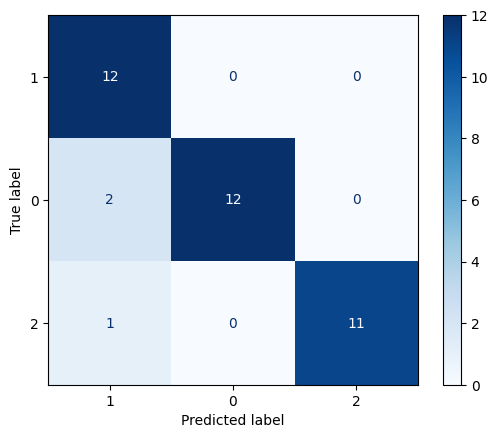

In [136]:
# We next display the confusion matrix.
labels = y_pred.unique()
cm = confusion_matrix(df.tail(38)['Y'], y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.show()

In [137]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(df.tail(38)['Y'], y_pred))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92        14
           1       0.80      1.00      0.89        12
           2       1.00      0.92      0.96        12

    accuracy                           0.92        38
   macro avg       0.93      0.92      0.92        38
weighted avg       0.94      0.92      0.92        38



Insights : The model achieves an accuracy of 0.92, demonstrating a strong overall classification performance across the three wine classes. Both the macro average and weighted average F1-score are 0.92, indicating that the model performs consistently well across all classes without significant bias toward any particular category.

When examining each class individually, Class 2 is predicted the best. It achieves an F1-score of 0.96 and a perfect precision of 1.00, meaning that every sample predicted as Class 2 is correct. Its recall of 0.92 shows that the model successfully identifies nearly all true Class 2 wines, with only one or two misclassified samples. This reflects excellent reliability in recognizing this class.

Class 0 also performs very well, with perfect precision (1.00) and a high F1-score (0.92). However, its recall (0.86) indicates that a few true Class 0 samples were misclassified as other classes—specifically, two of them were predicted as Class 1 according to the confusion matrix.

Class 1 is correctly identified with a recall of 1.00, meaning the model detects all true samples of this class. However, its precision (0.80) is lower, showing that some samples from other classes (mainly Class 0 and Class 2) were incorrectly predicted as Class 1. This explains the slightly lower F1-score (0.89) for this class.

Overall, the model shows a balanced and strong performance with minimal misclassifications. The confusion matrix reveals that most predictions fall along the diagonal, indicating high accuracy and reliable separation between the wine classes.

In [138]:
# Create new data points for the Wine dataset
# You can change these values to test different scenarios
new_data = {
'alcohol': [14.0, 14.00],
'malic_acid': [2.0, 2.0],
'ash': [2.3, 2.2],
'alcalinity_of_ash': [19.0, 11.0],
'magnesium': [95.0, 95.0],
'total_phenols': [2.2, 2.5],
'flavanoids': [0.14, 0.5],
'nonflavanoid_phenols': [0.14, 0.5],
'proanthocyanins': [1.6, 1.5],
'color_intensity': [7.0, 6.0],
'hue': [0.7, 0.6],
'od280/od315_of_diluted_wines': [3.2, 3.0],
'proline': [550.0, 1400.0]
}

new_wine_df = pd.DataFrame(new_data)

# Predict on the new wine data using the prism model trained on wine data
wine_prediction = prism.predict(new_wine_df)
# Assign predictions to a new column in the DataFrame
new_wine_df['Predicted Class'] = wine_prediction

# Display the new data and prediction
print("New Wine Data Points:")
display(new_wine_df)

New Wine Data Points:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Predicted Class
0,14.0,2.0,2.3,19.0,95.0,2.2,0.14,0.14,1.6,7.0,0.7,3.2,550.0,1
1,14.0,2.0,2.2,11.0,95.0,2.5,0.50,0.50,1.5,6.0,0.6,3.0,1400.0,2


Insights :
Data 1 (Row 0)
- Class 2 rule (flavanoids = Low AND hue = Low) : flavanoids = 0.14 is clearly Low; hue = 0.7 sits near a Low/Medium boundary and could be treated as Low depending on PRISM’s discretization thresholds. So this sample could match the Class 2 rule.
- Class 0 rule (proline High AND flavanoids High) :  does not match because flavanoids is Low (so Class 0 rule does not apply).
- Class 1 rule (color_intensity = Low) : does not match at face value because color_intensity = 7.0 looks high.
- PRISM uses discretized bins (Low / Med / High). If PRISM’s bin cutoffs were set differently, color_intensity = 7.0 may have been discretized to Low/Medium in the particular discretization used by your model, causing a Class 1 rule to fire.
- PRISM contains a fallback or higher-priority rule for Class 1 that this sample satisfied, or that multiple rules fired and the tie-breaking/priority mechanism picked Class 1.


Data 2 (Row 1)
- Class 2 rule (flavanoids = Low AND hue = Low) : flavanoids = 0.50 is at the low-to-mid range and hue = 0.6 is likely Low, so this sample plausibly matches the Class 2 rule.
- The other Class 2 rules we saw earlier (e.g., od280/od315 = Low AND alcalinity_of_ash = High) do not match here because alcalinity_of_ash = 11.0 is low/medium, not high.
- Class 0 rule (proline High AND flavanoids High) does not match because flavanoids is not High (even though proline is High).
- This sample satisfies the core Class 2 pattern (low flavonoids and low hue) used by the rule set you shared. PRISM therefore fired the Class 2 rule that strongly identifies Class 2 wines, and selected Class 2 as the predicted class.
- The high proline value did not cause Class 0 to be chosen because the Class 0 rule requires both proline and flavanoids to be High, and here flavanoids are not high.